In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Zadanie 2
## Pretraining
Wytrenowaliśmy model który uczył się generować zdjęcie płuc znajdujące się 3mm dalej od zdjęcia wejściowego. Jako funkcję straty wybraliśmy MSE, natomiast wyniki ocenialiśmy po MAE ponieważ MSE/RMSE potęguje duże błędy, a niweluje małe. W nasyzm wypadku duże błędy pojawiają się na granicy tkanek płucnych, które są najmniej istotne, a małe w wewnętrznych strukturach. Więc MAE wydaje się być lepszą metryką.

### Architektura

```
i = Input((None, None, 1))

#encoding layers
o = (ZeroPadding2D((1, 1)))(i)
o = (Convolution2D(64, (3, 3), padding='valid'))(o)
o = (BatchNormalization())(o)
o = (MaxPooling2D(pool_size=(2, 2)))(o)

o = (ZeroPadding2D((1, 1)))(o)
o = (Convolution2D(128, (3, 3), padding='valid'))(o)
o = (Activation('relu'))(o)
o = (BatchNormalization())(o)
o = (MaxPooling2D(pool_size=(2, 2)))(o)

o = (ZeroPadding2D((1, 1)))(o)
o = (Convolution2D(256, (3, 3), padding='valid'))(o)
o = (Activation('relu'))(o)
o = (BatchNormalization())(o)
o = (MaxPooling2D(pool_size=(2, 2)))(o)

o = (ZeroPadding2D((1, 1)))(o)
o = (Convolution2D(512, (3, 3), padding='valid'))(o)
o = (Activation('relu'))(o)
o = (BatchNormalization())(o)

#decoding layers
o = (ZeroPadding2D((1, 1)))(o)
o = (Convolution2D(512, (3, 3), padding='valid'))(o)
o = (BatchNormalization())(o)

o = (UpSampling2D((2, 2)))(o)
o = (ZeroPadding2D((1, 1)))(o)
o = (Convolution2D(256, (3, 3), padding='valid'))(o)
o = (BatchNormalization())(o)

o = (UpSampling2D((2, 2)))(o)
o = (ZeroPadding2D((1, 1)))(o)
o = (Convolution2D(128, (3, 3), padding='valid'))(o)
o = (BatchNormalization())(o)

o = (UpSampling2D((2, 2)))(o)
o = (ZeroPadding2D((1, 1)))(o)
o = (Convolution2D(64, (3, 3), padding='valid'))(o)
o = (BatchNormalization())(o)

model = Model(inputs=[i], outputs=[o])
```

Można zauważyć, że nie dodaliśmy ostatniej warstwy i sieć zwraca na wyjściu obrazki 512x512x64 zamiast 512x512. Mimo to Keras bez ostrzeżeń wytrenował taki model, a każde z 64 wyjść było bardzo podobne.  
Ten przypadek okazał się jednak całkiem słuszny, ponieważ sieci z dodaną ostatnią warstwą były znacznie bardziej podatne na przetrenowanie i bląd na zbiorze walidacyjnym eksplodował. Dlatego zdecydowaliśmy się zostawić sieć w takiej postaci.

### Trenowanie

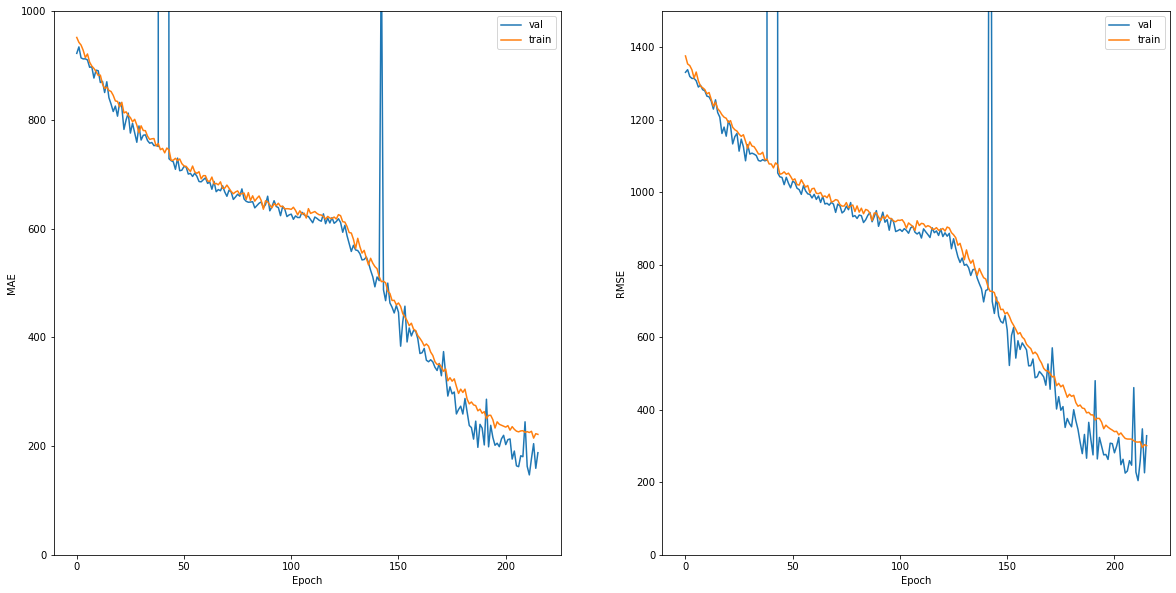

In [2]:
# Uruchamialiśmy trenowanie tego samego modelu trzy razy
# ponieważ modyfikowaliśmy learning rate w trakcie
models = ['model-20210508-034230', 'model-20210508-192141', 'model-20210508-214058']
logs = []
for m in models:
    logs.append(pd.read_csv('/opt/notebooks/LungNetSeq/' + m + '/training.log'))
logs = pd.concat(logs).reset_index(drop=True)
logs['epoch'] = logs.index

plt.rcParams["figure.figsize"] = (20,10)
plt.subplot(1,2,1)
plt.plot(logs['epoch'], logs['val_mean_absolute_error'], label='val')
plt.plot(logs['epoch'], logs['mean_absolute_error'], label='train')
plt.ylim([0, 1000])
plt.legend()
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.subplot(1,2,2)
plt.plot(logs['epoch'], logs['val_root_mean_squared_error'], label='val')
plt.plot(logs['epoch'], logs['root_mean_squared_error'], label='train')
plt.ylim([0, 1500])
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.show()

## Fine tunning

Do modelu powyżej dodaliśmy ostatnią warstwę z dwoma filtrami, tak aby wyjście odpowiadało liczbie klas oraz funkcję Softmax, która z poprzednich doświadczeń dawala nam najlepsze rezultaty dla tego zadania.  
Następnie wytrenowaliśmy kilka modeli za każdym razem zamrażając inną liczbę warstw.  
Na końcu porównaliśmy wyniki z modelem o ideantycznej architekturze trenowanym od zera.

In [3]:
models = [
    {'frozen': 0, 'mid': 'model-20210513-151653'},
    {'frozen': 6, 'mid': 'model-20210513-175425'},
    {'frozen': 11, 'mid': 'model-20210513-101256'},
    {'frozen': 16, 'mid': 'model-20210513-130758'},
    {'frozen': 20, 'mid': 'model-20210513-114427'}
]
for m in models:
    m['log'] = pd.read_csv('/opt/notebooks/LungNetSeq/' + m.get('mid') + '/training.log')

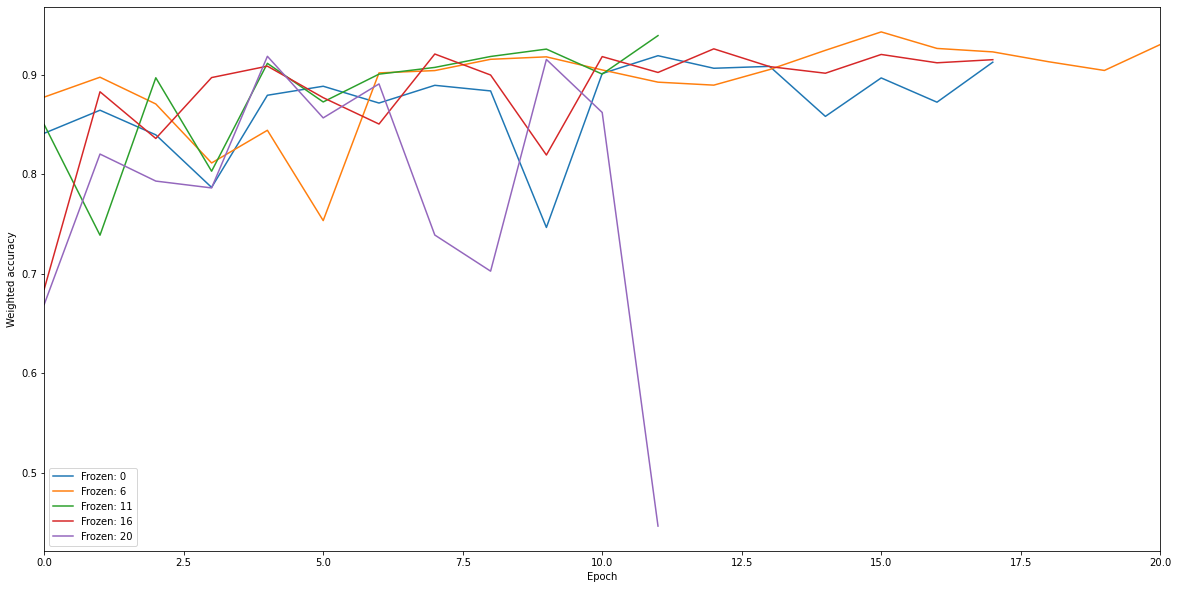

In [4]:
plt.rcParams["figure.figsize"] = (20,10)
for m in models:
    log = m.get('log')
    label = 'Frozen: %s' % m.get('frozen')
    plt.plot(log['epoch'], log['val_waccOA'], label=label)
plt.legend()
plt.ylabel('Weighted accuracy')
plt.xlabel('Epoch')
plt.xlim([0,20])
plt.show()

Trudno ocenić który poradził sobie najlepiej, ale subiektywnie wybraliśmy model z 11 zamrożonymi warstwami i uruchomiliśmy dłuższe trenowanie, żeby porównać go z modelem bez trenowania wstępnego

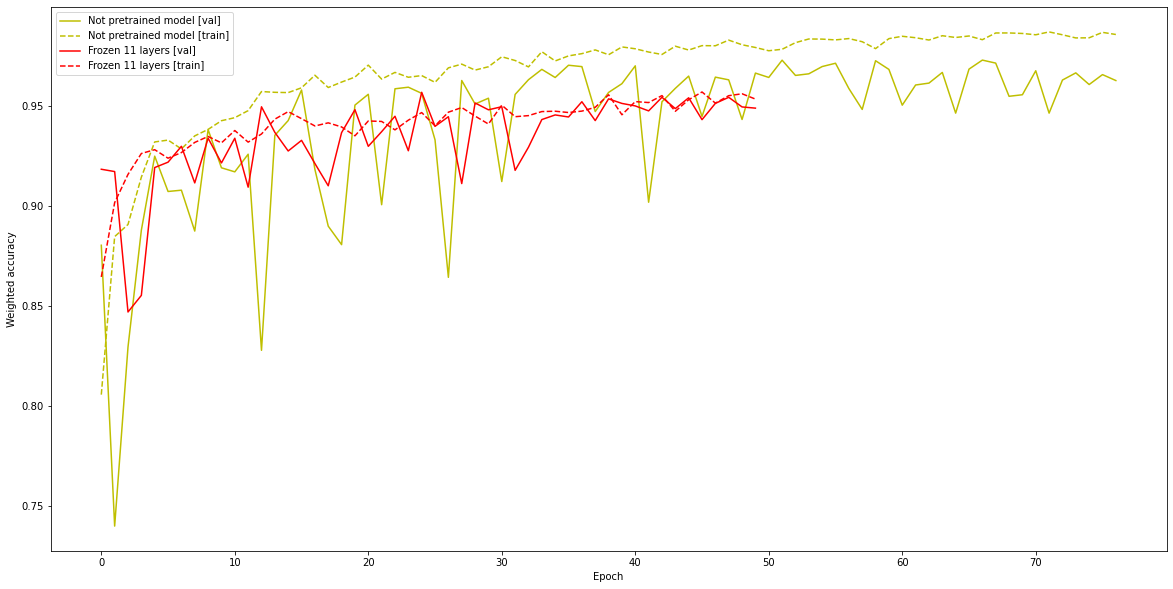

In [5]:
plt.rcParams["figure.figsize"] = (20,10)
base_log = pd.read_csv('/opt/notebooks/LungNetSeq/model-20210515-222117/training.log')
m11_log = pd.read_csv('/opt/notebooks/LungNetSeq/model-20210516-092626/training.log')

plt.plot(base_log['epoch'], base_log['val_waccOA'], 'y', label='Not pretrained model [val]')
plt.plot(base_log['epoch'], base_log['waccOA'], 'y--', label='Not pretrained model [train]')

plt.plot(m11_log['epoch'], m11_log['val_waccOA'], 'r', label='Frozen 11 layers [val]')
plt.plot(m11_log['epoch'], m11_log['waccOA'], 'r--', label='Frozen 11 layers [train]')


plt.legend()
plt.ylabel('Weighted accuracy')
plt.xlabel('Epoch')
plt.show()

#### Niestety pretrenowany model nie okazał się lepszy, ani też nie uczył się szybciej.